# Car price category predictor

I am using a car ad dataset from 2015 from Ebay marketplace.

The dataset has 11 fields and is used for categorization.

The price field is anywhere between 1 and 13. The numbers represent as following:
1 - price < 2000
2 - price < 3000
3 - price < 4000
4 - price < 5000
5 - price < 10000
6 - price < 15000
7 - price < 20000
8 - price < 25000
9 - price < 30000
10 - price < 40000
11 - price < 45000
12 - price < 50000
13 - price >= 50000

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

Let's import the data

In [2]:
cars = pd.read_csv('./datasets/cars.csv', index_col=None)

Let's see what the first ten rows look like to get a better understaning

In [3]:
cars.head(n=10)

,id,maker,mileage,manufacture_year,engine_displacement,engine_power,transmission,door_count,seat_count,fuel_type,price_eur
0,0,ford,151000,2011,2000,103,man,5,7,diesel,6
1,1,skoda,143476,2012,2000,81,man,5,5,diesel,5
2,2,bmw,97676,2010,1995,85,man,5,5,diesel,6
3,3,skoda,111970,2004,1200,47,man,5,5,gasoline,2
4,4,skoda,128886,2004,1200,47,man,5,5,gasoline,2
5,5,skoda,140932,2003,1200,40,man,5,5,gasoline,1
6,6,skoda,167220,2001,1400,74,man,5,5,gasoline,2
7,7,bmw,148500,2009,2000,130,auto,5,5,diesel,6
8,8,skoda,105389,2003,1900,81,man,5,5,diesel,4
9,9,skoda,41250,1990,1300,44,man,5,5,gasoline,1


In [4]:
cars.shape

(607868, 11)

In [5]:
cars.dtypes

id                      int64
maker                  object
mileage                 int64
manufacture_year        int64
engine_displacement     int64
engine_power            int64
transmission           object
door_count              int64
seat_count              int64
fuel_type              object
price_eur               int64
dtype: object

We can see that the majority of the fields are of type int, however we still have some str fields(named object here). We will have to encode those later because the machine learning algorithms use numeric data.

Lets see what type of data we have

In [6]:
cars.describe()

,id,mileage,manufacture_year,engine_displacement,engine_power,door_count,seat_count,price_eur
count,607868.000000,6.078680e+05,607868.000000,607868.000000,607868.000000,607868.000000,607868.000000,607868.000000
mean,303933.500000,1.042676e+05,2008.692004,1922.358486,105.041129,3.927341,4.888915,4.959443
std,175476.521053,1.000725e+05,6.410434,741.868944,52.542237,0.923465,0.841588,3.063327
min,0.000000,0.000000e+00,0.000000,10.000000,10.000000,1.000000,1.000000,1.000000
25%,151966.750000,2.830000e+04,2005.000000,1461.000000,74.000000,4.000000,5.000000,2.000000
50%,303933.500000,9.500000e+04,2010.000000,1896.000000,95.000000,4.000000,5.000000,5.000000
75%,455900.250000,1.590000e+05,2013.000000,2000.000000,125.000000,4.000000,5.000000,7.000000
max,607867.000000,9.999999e+06,2017.000000,32767.000000,999.000000,6.000000,74.000000,13.000000


We can see that there are cars from 2017 in the dataset, however the year of the dataset is 2015, we will have to fix that by setting those values to the mean value.  Also we see that the lowest manufacture year is 0, which is not possible as the oldest vehicle is from 1885. There also is an anomaly with engine displacement, however a quick google search shows that the biggest engine in fact was 46.9 liters, we'll let it slide. However the smallest engines are definetely a mistake, smallest engine ever fitted to a vehicle is 49cc not 10cc, therefore we will apply the mean value to it.

## Cleanup data

In [7]:
mean_manufacture_year = int(cars.describe()['manufacture_year']['mean'])
mean_manufacture_year

2008

In [8]:
mean_engine_displacement = int(cars.describe()['engine_displacement']['mean'])
mean_engine_displacement

1922

Let's adjust those wrong values

In [9]:
cars.loc[cars['manufacture_year'] < 1885, 'manufacture_year'] = mean_manufacture_year

In [10]:
cars.loc[cars['engine_displacement'] < 49, 'engine_displacement'] = mean_engine_displacement

Let's check the value descriptor again.

In [11]:
cars.describe()

,id,mileage,manufacture_year,engine_displacement,engine_power,door_count,seat_count,price_eur
count,607868.000000,6.078680e+05,607868.000000,607868.000000,607868.000000,607868.000000,607868.000000,607868.000000
mean,303933.500000,1.042676e+05,2008.695307,1922.411714,105.041129,3.927341,4.888915,4.959443
std,175476.521053,1.000725e+05,5.869919,741.800631,52.542237,0.923465,0.841588,3.063327
min,0.000000,0.000000e+00,1900.000000,54.000000,10.000000,1.000000,1.000000,1.000000
25%,151966.750000,2.830000e+04,2005.000000,1461.000000,74.000000,4.000000,5.000000,2.000000
50%,303933.500000,9.500000e+04,2010.000000,1896.000000,95.000000,4.000000,5.000000,5.000000
75%,455900.250000,1.590000e+05,2013.000000,2000.000000,125.000000,4.000000,5.000000,7.000000
max,607867.000000,9.999999e+06,2017.000000,32767.000000,999.000000,6.000000,74.000000,13.000000


Much nicer! Now we have more realistic data on our hands.

## Visualize data

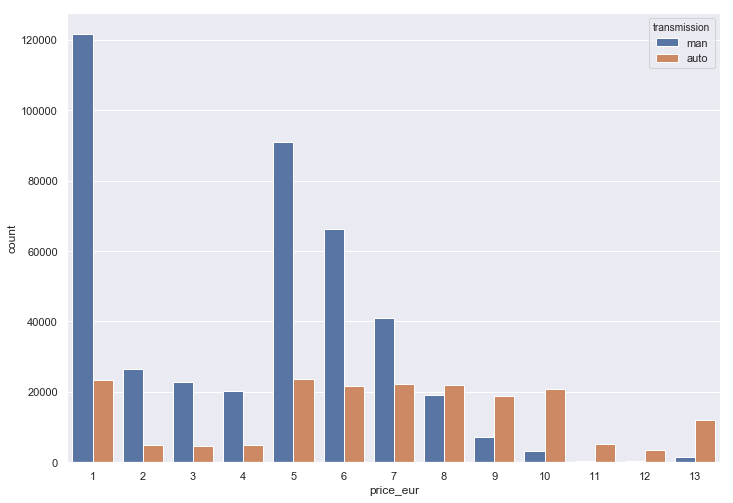

In [12]:
sns.set(style='whitegrid', color_codes=True)
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.countplot('price_eur', data=cars, hue='transmission')

Now we can see that the more expensive a car is it is more likely to have an automatic gearbox. Let's check the same with fuel

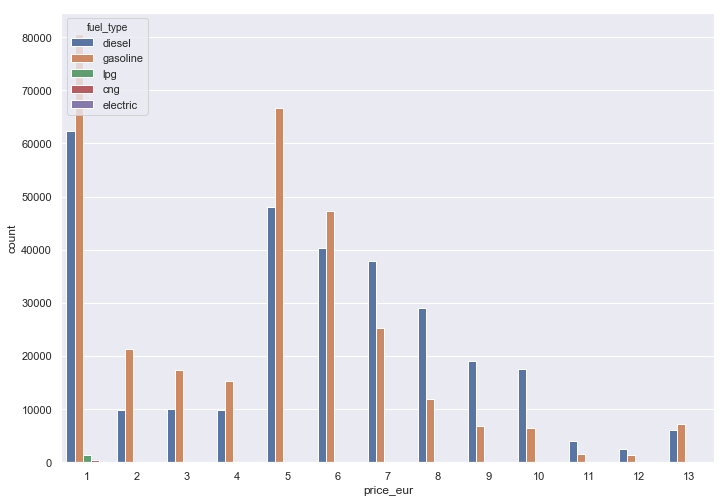

In [13]:
sns.countplot('price_eur', data=cars, hue='fuel_type')

Here we can see that diesel takes over the majority of vehicles in the mid-high price range and gasoline is in the cheaper scope. However, in the high-end gasoline pick up the majority as there is where all the fancy sports and luxury cars are.

## Preparing data

Machine learning algorithms use numeric values therefore we need to somehow encode the data that is represented in object format. I will use sklearn module LabelEncoder from preprocessing library. 

What LabelEncoder does it takes the unique values of each column and transform it to numeric representations (0 to whatever). The encoding happens alphabetically.

First let's see the unique values of each column.

In [14]:
print('Maker: ', cars['maker'].unique())
print('Transmission', cars['transmission'].unique())
print('fuel_type', cars['fuel_type'].unique())

Maker:  ['ford' 'skoda' 'bmw' 'suzuki' 'nissan' 'opel' 'citroen' 'seat' 'kia'
 'audi' 'rover' 'toyota' 'hyundai' 'fiat' 'volvo' 'chevrolet' 'mazda'
 'jeep' 'mercedes-benz' 'subaru' 'lancia' 'smart' 'chrysler' 'honda'
 'dodge' 'porsche' 'mitsubishi' 'mini' 'hummer' 'jaguar' 'lexus' 'bentley'
 'maserati' 'lamborghini' 'isuzu' 'lotus' 'tesla' 'volkswagen' 'renault'
 'peugeot' 'alfa-romeo' 'infinity' 'rolls-royce' 'aston-martin'
 'land-rover' 'dacia']
Transmission ['man' 'auto']
fuel_type ['diesel' 'gasoline' 'lpg' 'cng' 'electric']


In [15]:
len(cars['maker'].unique())

46

We have appearently have 46 different car manufacturers in our dataset.

Let's encode the data but before let's save that data for future use

In [16]:
makers = cars['maker'].unique()
transmissions = cars['transmission'].unique()
fuel_types = cars['fuel_type'].unique()

In [17]:
label_encoder = preprocessing.LabelEncoder()

In [18]:
cars['maker'] = label_encoder.fit_transform(cars['maker'])
cars['transmission'] = label_encoder.fit_transform(cars['transmission'])
cars['fuel_type'] = label_encoder.fit_transform(cars['fuel_type'])

In [19]:
makers_numeric = cars['maker'].unique()
transmissions_numeric = cars['transmission'].unique()
fuel_types_numeric = cars['fuel_type'].unique()

Let's see what the unique values look now

In [20]:
print('Maker: ', cars['maker'].unique())
print('Transmission', cars['transmission'].unique())
print('fuel_type', cars['fuel_type'].unique())

Maker:  [11 38  4 41 30 31  7 37 19  2 36 43 14 10 45  5 26 18 27 40 21 39  6 12
  9 33 29 28 13 17 23  3 25 20 16 24 42 44 34 32  0 15 35  1 22  8]
Transmission [1 0]
fuel_type [1 3 4 0 2]


## Data splitting

We need to seperate data into training set and testing, however since this data will never reflect the complete true as some of the car ads are created for fun with random data we will split 85% for training and only 15% for testing instead of usual 80/20 or 70/30

Let's first split data into target values and training on which we will do the guessing. We also need to remove id field as it does not provide any useful information and is only for indexing

In [21]:
cols = [col for col in cars.columns if col not in ['id', 'price_eur']]

data = cars[cols]
target = cars['price_eur']
data.head()

,maker,mileage,manufacture_year,engine_displacement,engine_power,transmission,door_count,seat_count,fuel_type
0,11,151000,2011,2000,103,1,5,7,1
1,38,143476,2012,2000,81,1,5,5,1
2,4,97676,2010,1995,85,1,5,5,1
3,38,111970,2004,1200,47,1,5,5,3
4,38,128886,2004,1200,47,1,5,5,3


In [22]:
target.head()

0    6
1    5
2    6
3    2
4    2
Name: price_eur, dtype: int64

In [23]:
data.shape

(607868, 9)

In [24]:
target.shape

(607868,)

The row count on both data and target matches! We successfuly split did the first split.

Time to split the data into training and test sets. For that I wil use the handy dandy too of train_test_split that does all the magic for us and then I am going to unpack it to multiple variables

In [25]:
data_train, data_test, target_train, target_test  = train_test_split(data, target, test_size=0.15, random_state=10)

In [26]:
data_train.shape

(516687, 9)

In [27]:
data_test.shape

(91181, 9)

In [28]:
target_train.shape

(516687,)

In [29]:
target_test.shape

(91181,)

## Building the model

### Naive-Bayes

In [30]:
gnb = GaussianNB()

naive_bayes_model = gnb.fit(data_train, target_train)

In [31]:
prediction = naive_bayes_model.predict(data_test)

In [32]:
print('Naive-Bayes accuracy: ', accuracy_score(target_test, prediction, normalize=True))

Naive-Bayes accuracy:  0.3751000756736601


We got a really low accuracy of barely 37.5%, not good, but the again the car market is always flawed with different vehicles and we would need 10x more data to get a precision of 80%+

### K-Neighbors

In [33]:
neigh_model = KNeighborsClassifier(n_neighbors=3)

neigh_model.fit(data_train, target_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [34]:
prediction = neigh_model.predict(data_test)

In [35]:
print('KNeigbors accuracy: ', accuracy_score(target_test, prediction, normalize = True))

KNeigbors accuracy:  0.46599620534979874


K-Neighbor seems to be better fitting the data we have and gets an accuracy of 46.5%, no ideal but much better the Naive-Bayes.

Therefore we will go with that, let's save it to a file so that we could use it further in our webapp. To do that I will use pickle module.

But before saving first create a new folder called models.

In [36]:
import os
os.mkdir('models')

In [37]:
with open('./models/CarPriceCategoryPredictor.pkl', 'wb') as f:
    pickle.dump(neigh_model, f)

# Webapp

Now we will create a webapp to implement the trained model before. We will load it from file system using sklearn tool called joblib that has a method load just to do that. We don't need to open any streams the method does it all itself and then returns the model we saved.

First of all it is required to have flask install

In [38]:
!pip install flask

Let's create a webapp file that will start the server

In [39]:
%%writefile webapp.py

from flask import Flask, request, render_template, Response, jsonify
from sklearn.externals import joblib

app = Flask(__name__, template_folder='./templates')

model = joblib.load('./models/CarPriceCategoryPredictor.pkl')

def class_to_range(price_class):
    if price_class == 1:
        return {'max': 2000}
    elif price_class == 2:
        return {'min': 2000, 'max': 3000}
    elif price_class == 3:
        return {'min': 3000, 'max': 4000}
    elif price_class == 4:
        return {'min': 4000, 'max': 5000}
    elif price_class == 5:
        return {'min': 5000, 'max': 10000}
    elif price_class == 6:
        return {'min': 10000, 'max': 15000}
    elif price_class == 7:
        return {'min': 15000, 'max': 20000}
    elif price_class == 8:
        return {'min': 20000, 'max': 25000}
    elif price_class == 9:
        return {'min': 25000, 'max': 30000}
    elif price_class == 10:
        return {'min': 30000, 'max': 40000}
    elif price_class == 11:
        return {'min': 40000, 'max': 50000}
    else:
        return {'min': 50000}

@app.route('/', methods=['GET'])
def index():
    return render_template('index.html')

@app.route('/predict', methods=["POST"])
def predict():
    data = dict(request.form)

    X = [[
        int(data['maker']), 
        int(data['mileage']),
        int(data['year']),
        int(data['engine_displacement']),
        int(data['engine_power']),
        int(data['transmission']),
        int(data['door_count']),
        int(data['seat_count']),
        int(data['fuel_type'])
        ]]

    predicted = model.predict(X)
    result = class_to_range(predicted[0])
    return jsonify(result)

if __name__ == "__main__":
    app.run(debug=True)

Writing webapp.py


But now we don't have any views, let's do that. First of all we need to create a new folder to store them, we call the template folder 'templates'

In [40]:
import os
os.mkdir('templates')

Now that we have our temlates folder let's add the view. We will have two files, base.html and index.html to seperate the setup and the more logic like blocks

In [41]:
%%writefile templates/base.html

<!DOCTYPE html>
<head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">

    <title>{% block title %}{% endblock %}</title>

    <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/css/bootstrap.min.css" integrity="sha384-ggOyR0iXCbMQv3Xipma34MD+dH/1fQ784/j6cY/iJTQUOhcWr7x9JvoRxT2MZw1T" crossorigin="anonymous">
</head>
<body>
    <div class="container">
        {% block content %}
        {% endblock %}
    </div>

<script src="https://code.jquery.com/jquery-3.4.1.js" integrity="sha256-WpOohJOqMqqyKL9FccASB9O0KwACQJpFTUBLTYOVvVU=" crossorigin="anonymous"></script>
<script src="https://cdnjs.cloudflare.com/ajax/libs/popper.js/1.14.7/umd/popper.min.js" integrity="sha384-UO2eT0CpHqdSJQ6hJty5KVphtPhzWj9WO1clHTMGa3JDZwrnQq4sF86dIHNDz0W1" crossorigin="anonymous"></script>
<script src="https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/js/bootstrap.min.js" integrity="sha384-JjSmVgyd0p3pXB1rRibZUAYoIIy6OrQ6VrjIEaFf/nJGzIxFDsf4x0xIM+B07jRM" crossorigin="anonymous"></script>

{% block scripts %}

{% endblock %}
</body>

Writing templates/base.html


In [42]:
%%writefile templates/index.html

{% extends "base.html" %}

{% block title %} Price predictor {% endblock %}

{% block content %}
<form>
    <div class="form-row">
        <div class="form-group col-md-12">
            <label for="maker">Manufacturer</label>
            <select class="custom-select" id="maker" name="maker">
                <option value="11">Ford</option>
                <option value="38">Skoda</option>
                <option value="4">Bmw</option>
                <option value="41">Suzuki</option>
                <option value="30">Nissan</option>
                <option value="31">Opel</option>
                <option value="7">Citroen</option>
                <option value="37">Seat</option>
                <option value="19">Kia</option>
                <option value="2">Audi</option>
                <option value="36">Rover</option>
                <option value="43">Toyota</option>
                <option value="14">Hyundai</option>
                <option value="10">Fiat</option>
                <option value="45">Volvo</option>
                <option value="5">Chevrolet</option>
                <option value="26">Mazda</option>
                <option value="18">Jeep</option>
                <option value="27">Mercedes-benz</option>
                <option value="40">Subaru</option>
                <option value="21">Lancia</option>
                <option value="39">Smart</option>
                <option value="6">Chrysler</option>
                <option value="12">Honda</option>
                <option value="9">Dodge</option>
                <option value="33">Porsche</option>
                <option value="29">Mitsubishi</option>
                <option value="28">Mini</option>
                <option value="13">Hummer</option>
                <option value="17">Jaguar</option>
                <option value="23">Lexus</option>
                <option value="3">Bentley</option>
                <option value="25">Maserati</option>
                <option value="20">Lamborghini</option>
                <option value="16">Isuzu</option>
                <option value="24">Lotus</option>
                <option value="42">Tesla</option>
                <option value="44">Volkswagen</option>
                <option value="34">Renault</option>
                <option value="32">Peugeot</option>
                <option value="0">Alfa-romeo</option>
                <option value="15">Infinity</option>
                <option value="35">Rolls-royce</option>
                <option value="1">Aston-martin</option>
                <option value="22">Land-rover</option>
                <option value="8">Dacia</option>
            </select>
        </div>
    </div>
    <div class="form-row">
        <div class="form-group col-md-6">
            <label for="mileage">Mileage</label>
            <input type="number" class="form-control" min="0" id="mileage" name="mileage" value="0">
        </div>
        <div class="form-group col-md-6">
            <label for="manufacture_year">Year</label>
            <input type="number" class="form-control" min="1885" max="2019" id="manufacture_year" name="manufacture_year" value="2010">
        </div>
    </div>
    <div class="form-row">
        <div class="form-group col-md-6">
            <label for="transmission">Gearbox</label>
            <select class="custom-select" id="transmission" name="transmission">
                <option value="1">Manual</option>                
                <option value="0">Automatic</option>
            </select>
        </div>
        <div class="form-group col-md-6">
            <label for="fuel_type">Fuel Type</label>
            <select class="custom-select" id="fuel_type" name="fuel_type">
                <option value="3">Petrol</option>                
                <option value="1">Diesel</option>
                <option value="4">LPG</option>
                <option value="0">CNG</option>
                <option value="2">Electric</option>
            </select>
        </div>
    </div>
    <div class="form-row">
        <div class="form-group col-md-6">
            <label for="engine_displacement">Engine displacement (cm^3)</label>
            <input type="number" class="form-control" id="engine_displacement" name="engine_displacement" min="500" max="8000" step="5" value="2000">
        </div>
        <div class="form-group col-md-6">
            <label for="engine_power">Engine power (kw)</label>
            <input type="number" class="form-control" id="engine_power" name="engine_power" min="1" max="1000" value="81">
        </div>
    </div>
    <div class="form-row">
        <div class="form-group col-md-6">
            <label for="door_count">Door count</label>
            <select class="custom-select" id="door_count" name="door_count">
                <option value="2">2/3</option>                
                <option value="4">4</option>
                <option value="5">4/5</option>
                <option value="6">6</option>
                <option value="1">1</option>
            </select>
        </div>
        <div class="form-group col-md-6">
            <label for="seat_count">Seat count</label>
            <input type="number" class="form-control" id="seat_count" name="seat_count" min="1" max="100" value="5">
        </div>
    </div>
    <button type="submit" class="btn btn-success">Submit</button>
</form>

<p class="lead" id="car_value_p" style="display: none">Price should be <span id="car_value"></span></p>
{% endblock %}

{% block scripts %}
<script>
    $('form').submit((e) => {
        var vehicle = {};
        vehicle.maker = $('#maker').val();
        vehicle.mileage = $('#mileage').val();
        vehicle.year = $('#manufacture_year').val();
        vehicle.transmission = $('#transmission').val();
        vehicle.fuel_type = $('#fuel_type').val();
        vehicle.engine_displacement = $('#engine_displacement').val();
        vehicle.fuel_type = $('#fuel_type').val();
        vehicle.engine_power = $('#engine_power').val();
        vehicle.door_count = $('#door_count').val();
        vehicle.seat_count = $('#seat_count').val();

        $.ajax({
            url: '/predict',
            method: 'POST',
            data: vehicle,
            success: (response) => {
                console.log(response)
                if(response.max) {
                    if(response.min) {
                        // there are both min and max values
                        $('#car_value').html(`in between ${response.min} and ${response.max} euros.`);
                    } else {
                        // only max value
                        $('#car_value').html(`below ${response.max} euros.`);
                    }
                } else {
                    // only min value defined
                    $('#car_value').html(`above ${response.min} euros.`);
                }
                $('#car_value_p').show()
            },
            error: (err) => {
                alert('An error occured!');
            }
        });

        return false;
    });
</script>
{% endblock %}

Writing templates/index.html


We left the action and method not set because we are using jQuery to parse it all and send it to the server via ajax therefore not requiring any reloads.

Let's start the application

In [ ]:
!python webapp.py